In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

from matplotlib import cm
from matplotlib.ticker import LinearLocator
from ifu_helpers import *
from sag_ray_solns import *

In [2]:
%matplotlib ipympl

In [3]:
def conic_3d_transfer(xt, yt, l, m, n, c, k, alpha, beta, gamma):
    """Returns the transfer distance. Because the equation for t is a quadratic,
    there are two possible solutions. We almost always want the solution that
    corresponds to a smaller value of t (+ )

    See Cheatham 1980.
    """
    alpha = convert_angle(alpha) * np.pi/180
    beta = convert_angle(beta) * np.pi/180
    gamma = convert_angle(gamma) * np.pi/180
    if abs(gamma) <= np.pi/2:
        sgn = 1
    else:
        sgn = -1
        
    # Determine the off-axis distance.
    if (abs(c) < 1e-13): c = 1e-13
        
    y0 = np.sin(alpha) / ( c * (1+np.cos(alpha)) )
    x0 = np.sin(beta) / ( c * (1+np.cos(beta)) )
    
    # Sign of solution also depends on whether concave or convex
    sgn *= abs(c) / c

    cosg = np.cos(gamma)
    cosg2 = cosg*cosg
    sing = np.sin(gamma)
    sing2 = sing*sing
    
    xi = cosg2 + (1+k)*sing2
    A = c*(sing2 + (1+k)*cosg2)
    dsol = A*n*n - 2*l*n*k*c*sing*cosg + c*l*l*xi + m*m*c
    fsol = -xt*n*k*c*sing*cosg - n*cosg + l*sing + c*xt*l*xi + yt*m*c
    gsol = 2*xt*sing + c*xt*xt*xi + c*yt*yt
    
    # Ray missed this surface
    if fsol**2-dsol*gsol < 0:
        return np.nan
        
    return gsol/(-fsol + sgn*np.sqrt(fsol*fsol - dsol*gsol))

In [53]:
def ray_trace_slicer(xt, yt, l, m, n, p, sag_func, critical_xy_func, transfer_dist_func, surf_normal_func):
    """Computes ray trace.
    
    Returns
    -------
    xs, ys, zs
    """
    # Tolerance for accepting the transfer distance as valid
    tol = 1e-10
    
    if abs(n) < 1e-13:
        # Ray is moving perpendicular to the z-axis! This is an unusual case.
        # Set bounds on potential xs and ys to edges of the image slicer
        xsize, ysize = get_slicer_size(p)
        xmin, xmax = -xsize/2, xsize/2
        ymin, ymax = -ysize/2, ysize/2
        
        if l < 0: xmin *= -1; xmax *= -1  # propagate right to left
        if m < 0: ymin *= -1; ymax *= -1  # propagate bottom to top
        
    else:
        # Get maximum and minimum possible values of xs and ys
        zmin, zmax = find_global_extrema_slicer(p, sag_func, critical_xy_func)
        tmin = zmin / n
        xmin, ymin = xt + tmin*l, yt + tmin*m
        tmax = zmax / n
        xmax, ymax = xt + tmax*l, yt + tmax*m

    # Get starting and ending rows and columns
    nc_min, ns_min = get_slicer_index(xmin, ymin, p)
    nc_max, ns_max = get_slicer_index(xmax, ymax, p)
    
    # Check if the ray is always out of bounds
    n_sperc = p.n_each * p.n_rows  # number of slices per column
    if (nc_min < 0 and nc_max < 0) or (nc_min >= p.n_cols and nc_max >= p.n_cols):
        # x-value of the ray is too high or low
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    if (ns_min < 0 and ns_max < 0) or (ns_min >= n_sperc and ns_max >= n_sperc):
        # y-value of the ray is too high or low
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    # Ray is in bounds at least some of the time. Start from the min col and slice
    # indices and check solutions until we hit the max
    nc_test, ns_test = nc_min, ns_min
    x_test, y_test = xt, yt

    dcol = abs(nc_max - nc_test)        # Number of col indices left to iterate
    dslice = abs(ns_max - ns_test)      # Number of slice (row) indices left to iterate

    # Keep track of signs - which way to iterate
    sgnc = 0
    sgns = 0
    if dcol > 0:
        sgnc = (nc_max - nc_min) / dcol     
    if dslice > 0:
        sgns = (ns_max - ns_min) / dslice 
    
    sgnres = np.nan     # Sign of transfer function
    slice_iter = 0      # Keep track of whether we're on the first slice in a column to check walls
    
    while dcol >= 0:

        # How many slices do we need to check on this column?
           
        # No column switching needed, check all remaining slices
        if (abs(l) < 1e-13 or dcol == 0):
            n_sforc = dslice

        # Ray can potentially switch columns
        else:
            # Crossover point between current column and next one
            x_cross = nc_test * (p.dx + p.gx_width) + (1 + sgnc) * dx / 2
            # y-intercept between ray and the next column to check
            y_cross = yt + (x_cross - x_test) * m / l
            # Number of slices to check
            n_sforc = math.ceil(abs(y_cross - y_test) / (p.dy + p.gy_width))
            x_test, y_test = x_cross, y_cross
            
        while (dslice >= 0 and n_sforc >= 0):
            
            # Check if out of bounds
            alpha, beta, gamma = get_slice_angles(ns_test, nc_test, p)
            t = transfer_dist_func(xt, yt, l, m, n, p.c, p.k, alpha, beta, gamma)
            result = transfer_equation(t, xt, yt, l, m, n, p, sag_func)

            if not np.isnan(result):  
                # Check whether the transfer distance of the current slice is a valid
                # zero of the transfer equation.
                
                # Keep track of the sign. This is needed to know if we hit a wall.
                sgnres = abs(result) / result
                
                if abs(result) < tol:
                    # Yes - found a solution!
                    xs = xt + t*l
                    ys = yt + t*m
                    zs = t*n
                    ln, mn, nn = surf_normal_func(xs, ys, p.c, p.k, alpha, beta, gamma)

                    # WAIT - Is the solution inside of a gap? If we're unlucky and zs is
                    # equal to the gap depth then this may be the case.
                    in_xgap, in_ygap = is_inside_slicer_gap(xs, ys, p)
                    if (in_xgap or in_ygap):
                        dcol = -1
                        break
                    
                    # Check which side the ray entered the surface. The ray and surface normal
                    # should be facing opposite directions. If the dot product is positive, then
                    # the ray entered from the wrong side. Say that the ray missed.
                    if (t*l*ln + t*m*mn + t*n*nn < 0):
                        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
                        
                    return xs, ys, zs, t, ln, mn, nn

                # Check if the sign of the transfer equation flipped. If yes, the ray must have
                # slipped between two of the slices and hit a wall.
                if sgnres*sgnres == -1:
                    
                    # Say that the ray missed and return without tracing the walls
                    if not p.trace_walls:
                        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

                    # If we just incremented a column then the ray must have hit a wall between
                    # two columns
                    if (slice_iter == 0 and abs(l) > 1e-13):
                        # Geometrically the ray must have hit the wall farther away from
                        # the current slice (towards +z; adjacent to the next slice over).
                        # This equation works regardless of whether there are gaps or not.
                        xs = ns_test * p.dx + sgns * p.gx_width
                        t = (xs - xt) / l
                        xs = yt + t*m
                        zs = t*n
                        return xs, ys, zs, t, -1*sgnc, 0, 0
                    
                    # Must have been a gap on the y-axis
                    if abs(m) > 1e-13:
                        ys = ns_test * p.dy + sgns * p.gy_width
                        t = (ys - yt) / m
                        xs = xt + t*l
                        zs = t*n
                        return xs, ys, zs, t, 0, -1*sgns, 0

            # Not a solution - increment slice and try again.
            slice_iter += 1
            ns_test += 1 * sgns
            dslice -= 1

        # The last slice index needs to be checked again when crossing over to the next column
        slice_iter = 0
        ns_test -= 1 * sgns
        dslice += 1
        # Go to the next column
        nc_test += 1 * sgnc
        dcol -= 1

    # If none of the above worked then we probably hit a gap
    if (not p.trace_walls or abs(n) < 1e-13):
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    # Gaps between columns take precedence over gaps between slices in rows
    if in_xgap:
        t = p.gx_depth / n
        return xt + t*l, yt + t*m, p.gx_depth, t, 0, 0, -1
    elif in_ygap:
        t = p.gy_depth / n
        return xt + t*l, yt + t*m, p.gy_depth, t, 0, 0, -1

    # If none of that worked then this is a bizarre and extreme edge case, e.g., the direction
    # cosine is less than 1E-13 but it grazed off of a wall somehow. Sweep this ray under the
    # rug and say that it missed...
    return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan    # Phew!


analytic soln: 0.17993810256700668
numerical soln:0.1717171717171717


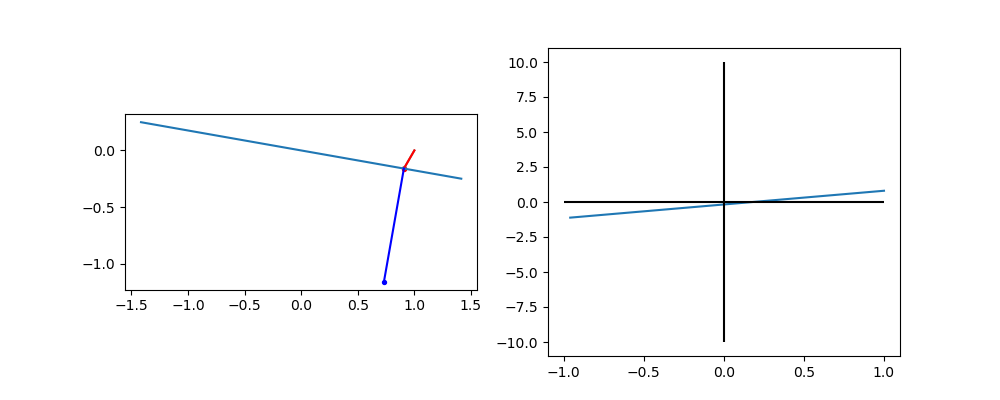

In [65]:
sag_func = tilted_plane_sag
surface_norm_func = tilted_plane_surface_normal
transfer_dist_func = tilted_plane_transfer
critical_xy_func = tilted_plane_critical_xy

"""
sag_func = conic_3d_sag
surface_norm_func = conic_3d_surface_normal
transfer_dist_func = conic_3d_transfer
critical_xy_func = conic_3d_critical_xy
"""

n_each = 1
n_rows = 1
n_cols = 1
mode = 1
trace_walls = False
dalpha = 0
dbeta = 0
dgamma = 0
alpha_cen = 10
beta_cen = 0
gamma_cen = 5
dx = 10
dy = 3
r = -100
c = 1/r
k = 0
xgap_width = 0
xgap_depth = 2
ygap_width = 0
ygap_depth = 2
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, trace_walls, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, xgap_width, xgap_depth, ygap_width, ygap_depth)

xt = 0
y = np.linspace(-20, 20, 100)
surf = np.zeros(len(y))
for i,y1 in enumerate(y):
    surf[i] = make_image_slicer(xt, y1, p, sag_func)


yt = 1
l = 0
m = -0.6
n = -1
l = l / np.sqrt(l*l+m*m+n*n)
m = m / np.sqrt(l*l+m*m+n*n)
n = n / np.sqrt(l*l+m*m+n*n)

xs, ys, zs, tsol, ln, mn, nn = ray_trace_slicer(xt, yt, l, m, n, p, sag_func, critical_xy_func, transfer_dist_func, surface_norm_func)
print("analytic soln: " + str(tsol))

t = np.linspace(-1, 1, 100)
feval = np.zeros(len(t))
for i,t1 in enumerate(t):
    feval[i] = transfer_equation(t1, xt, yt, l, m, n, p, sag_func)
idx = np.nanargmin(np.abs(feval))
tnum = t[idx]
print("numerical soln:" + str(tnum))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs[0].plot(y, surf)

# Draw analytically calculated ray and surface normal
axs[0].plot([yt, yt + tsol*m], [0, tsol*n], c='r', zorder=1)
axs[0].scatter([yt + tsol*m], [tsol*n], c='r', s=8, zorder=1)
axs[0].plot([ys, ys+mn], [zs, zs+nn], c='b')
axs[0].scatter([ys+mn], [zs+nn], c='b', s=8, zorder=10)

# Numerically determined ray
axs[0].plot([yt, yt + tnum*m], [0, tnum*n], c='gray', zorder=0)
axs[0].scatter([yt + tnum*m], [tnum*n], c='gray', s=8, zorder=0)
axs[0].set_aspect("equal")

axs[1].plot(t, feval)
axs[1].hlines(0, t[0], t[-1], colors='k')
axs[1].vlines(0, -10, 10, colors='k')
#axs[1].set_ylim(np.nanmin(feval), np.nanmax(feval))

plt.show()

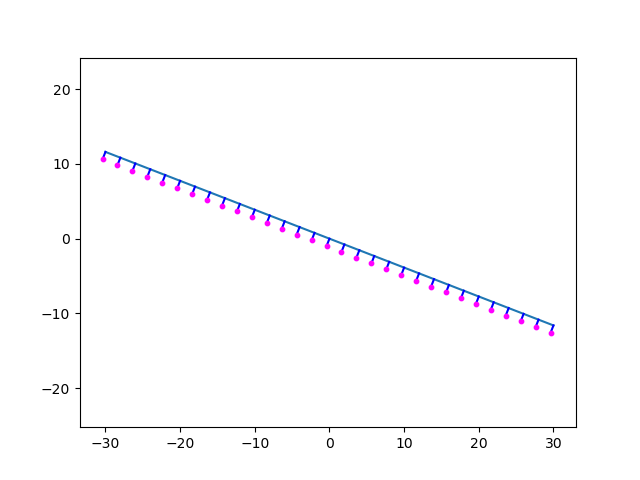

In [48]:
sag_func = tilted_plane_sag
surface_norm_func = tilted_plane_surface_normal
#sag_func = conic_3d_sag
#surface_norm_func = #conic_3d_surface_normal

xs = np.linspace(-30,30,100)
y0 = 0
r = -50
c = 1/r
k = 0
alpha = -20
beta = 10
gamma = -30

surface = sag_func(xs, y0, c, k, alpha, beta, gamma)

#print(conic_3d_sag_critical_x_y(c, k, 0, 2, gamma))


#idx = np.argmin(surface)
#print(xs[idx])

plt.figure()
plt.plot(xs, surface)

for xtest in np.arange(-30, 30.1, 2):
    nx, ny, nz = surface_norm_func(xtest, y0, c, k, alpha, beta, gamma)
    ztest = sag_func(xtest, y0, c, k, alpha, beta, gamma)
    plt.plot([xtest, xtest+nx], [ztest, ztest+nz], c='b')
    plt.scatter([xtest+nx], [ztest+nz], c='fuchsia', s=10, zorder=10)
    #plt.plot([xtest, xtest-c*xtest], [ztest, ztest+1-c*ztest], c='r')
plt.plot()
plt.axis("equal")
#plt.plot([xtest, xtest-c*xtest], [ztest, ztest+1-c*ztest], c='r')
#plt.ylim(-1,4)
#plt.scatter(xs[idx], surface[idx], c='r')
plt.show()

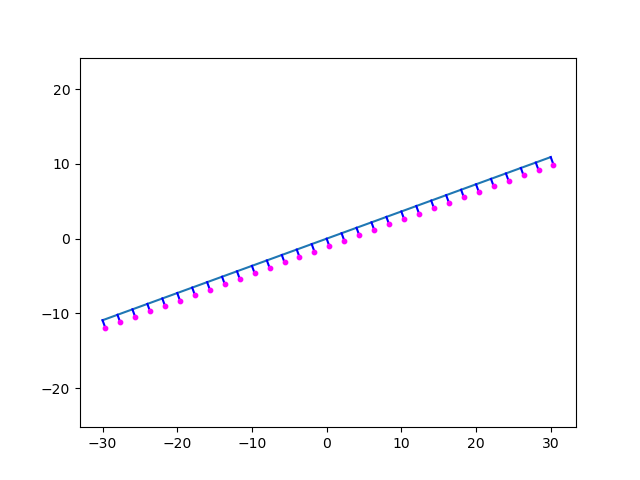

In [47]:
ys = np.linspace(-30,30,100)
x0 = 0

surface = sag_func(x0, ys, c, k, alpha, beta, gamma)

plt.figure()
plt.plot(ys, surface)

for ytest in np.arange(-30, 30.1, 2):
    nx, ny, nz = surface_norm_func(x0, ytest, c, k, alpha, beta, gamma)
    ztest = sag_func(x0, ytest, c, k, alpha, beta, gamma)
    plt.plot([ytest, ytest+ny], [ztest, ztest+nz], c='b')
    plt.scatter([ytest+ny], [ztest+nz], c='fuchsia', s=10, zorder=10)
    #plt.plot([ytest, ytest-c*ytest], [ztest, ztest+1-c*ztest], c='r'
plt.axis("equal")
plt.show()

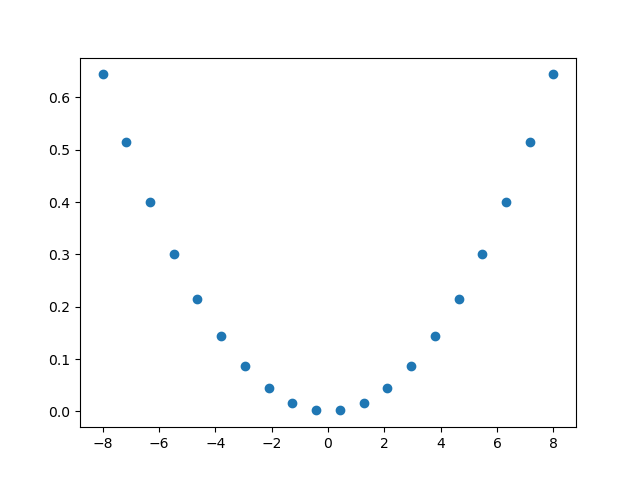

In [7]:
n_each = 1
n_rows = 1
n_cols = 1
mode = 0
dalpha = -20
dbeta = 0
dgamma = 10
alpha_cen = 0
beta_cen = 0
gamma_cen = 0
dx = 15
dy = 5
r = 50
c = 1/r
k = -1
gx_width = 0
gx_depth = np.nan
gy_width = 0
gy_depth = np.nan
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, False, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, gx_width, gx_depth, gy_width, gy_depth)

N = 20
r = 20
k = 0
t = -10

y = np.linspace(-8, 8, N)
x = np.linspace(-8, 8, N)
z = conic_3d_sag(x, 0, c, k, 0, 0, 0)

plt.figure()
plt.scatter(x, z)
plt.show()

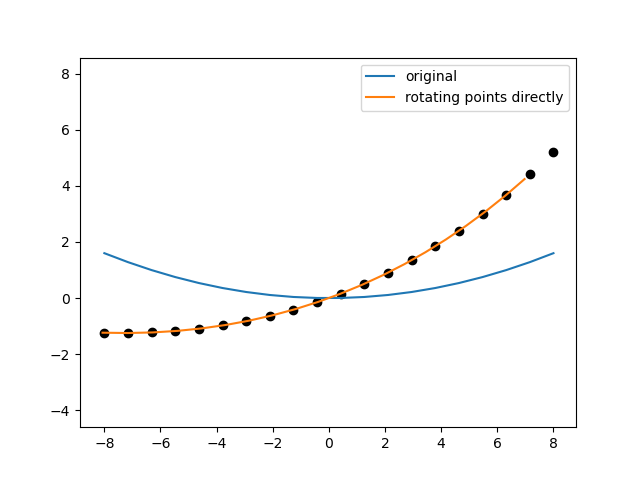

In [9]:
N = 20
r = 20
k = -1
t = 20

# perform the rotation manually with a rotation matrix
x1 = np.linspace(-8, 8, N)
y1 = []
x2 = []
y2 = []
#y3 = []
trad = -t*np.pi/180

for i in range(N):
    y1.append(conic(x1[i],r,k))
    xnew = x1[i]*np.cos(trad)+y1[i]*np.sin(trad)
    ynew = -x1[i]*np.sin(trad)+y1[i]*np.cos(trad)
    x2.append(xnew)
    y2.append(ynew)
    #y3.append(rotated_conic(x1[i], r, k, t))

y3 = conic_3d_sag(x1, 0, 1/r, k, 0, 0, t)
plt.figure()
plt.plot(x1,y1,label='original')
plt.plot(x2,y2,label='rotating points directly')
plt.scatter(x1,y3,c='k')
#plt.vlines([-2,0,2], -1, 1)
#plt.ylim(0,8)
#plt.xlim(-8,8)
plt.axis('equal')
plt.legend()
#plt.savefig("rotated_conics.png",dpi=300,facecolor="white")
plt.show()

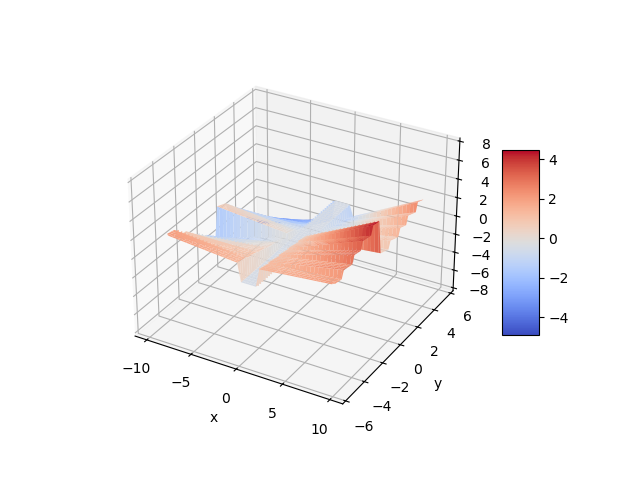

In [27]:
sag_func = tilted_plane_sag#conic_3d_sag

n_each = 5
n_rows = 2
n_cols = 2
mode = 1
trace_gaps = False
dalpha = 10
dbeta = 10
dgamma = 5
alpha_cen = 20
beta_cen = 10
gamma_cen = 0
dx = 8
dy = 1
r = 50
c = 1/r
k = 0
xgap_width = 2
xgap_depth = -0.5
ygap_width = 0
ygap_depth = -0.8
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, trace_gaps, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, xgap_width, xgap_depth, ygap_width, ygap_depth)
xsize, ysize = get_slicer_size(p)

N = 500

#Nx = n_cols * 8
#Ny = n_rows * n_each * 8
x = np.linspace(-1.1*xsize/2,1.1*xsize/2,N)
y = np.linspace(-1.1*ysize/2,1.1*ysize/2,N)

Z = np.zeros((N,N))
for i,x1 in enumerate(x):
    for j,y1 in enumerate(y):
        Z[j,i]=make_image_slicer(x1, y1, p, sag_func)
        #Z[i,j]=make_image_slicer2(x1, y1, n_each, dalpha, dbeta, alpha_cen, beta_cen, dx, dy, rx, ry, kx, ky)
    

X, Y = np.meshgrid(x, y)
#Z2 = make_slice(X, Y, rx, ry, kx, ky, 0, 0)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
#ax.scatter(9.487179487179485,-4.364548494983277,-0.6999614810235664, c='g')
#ax.scatter(9.487179487179485,14.899665551839465,3.8157755724491054, c='g')
#surf = ax.plot_surface(X, Y, Z2, cmap=cm.viridis)
#ax.zaxis.set_major_formatter('{x:.02f}')
#ax.view_init(azim=90, elev=0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlim(-8, 8)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [46]:
def rotatebackward3d(x, y, z, alpha,beta):
    alpha = convert_angle(alpha) * np.pi/180
    beta = convert_angle(beta) * np.pi/180
    cosa = np.cos(alpha)
    cosa2 = cosa*cosa
    sina = np.sin(alpha)
    sina2 = sina*sina
    cosb = np.cos(beta)
    cosb2 = cosb*cosb
    sinb = np.sin(beta)
    sinb2 = sinb*sinb
    
    # Inverse transformation matrix for a 3D rotation about the global x- and y-axes
    det = cosa2*cosb2 + cosb2*sina2 + cosa2*sinb2 + sina2*sinb2
    a = (cosa2*cosb + cosb*sina2) / det
    b = sina*sinb / det
    c = -1*cosa*sinb / det
    d = (cosa*cosb2 + cosa*sinb2) / det
    f = (cosb2*sina + sina*sinb2) / det
    g = (cosa2*sinb + sina2*sinb) / det
    h = -1*cosb*sina / det
    m = cosa*cosb / det
    xp = a*x + b*y + c*z
    yp = d*y + f*z
    zp = g*x + h*y + m*z
    #print([[a,b,c],[0,d,f],[g,h,m]])
    xp = a*x + b*y + c*z
    yp = d*y + f*z
    zp = g*x + h*y + m*z
    return xp, yp, zp

def rotateforward3d(x,y,z,alpha,beta):
    alpha = convert_angle(alpha) * np.pi/180
    beta = convert_angle(beta) * np.pi/180
    cosa = np.cos(alpha)
    cosa2 = cosa*cosa
    sina = np.sin(alpha)
    sina2 = sina*sina
    cosb = np.cos(beta)
    cosb2 = cosb*cosb
    sinb = np.sin(beta)
    sinb2 = sinb*sinb
    
    xp = x*cosb + y*sinb
    yp = x*sina*sinb + y*cosa - z*cosb*sina
    zp = -x*cosa*sinb + y*sina + z*cosa*cosb
    return xp, yp, zp


alpha=10
beta=20

N = 30
x = np.linspace(-10,10,N)
y = np.linspace(-10,10,N)

xold = []
yold = []
zold = []
xnew = []
ynew = []
znew = []

Z = np.zeros((N,N))

for i,x1 in enumerate(x):
    for j,y1 in enumerate(y):
        z1 = rotated_conic_3d(x1,y1,20,20,0,0,0,0)
        Z[i,j] = z1
        x1po, y1po, z1po = rotateforward3d(x1,y1,z1,alpha,beta)
        x1p, y1p, z1p = rotatebackward3d(x1po, y1po, z1po, alpha, beta)
        xold.append(x1po)
        yold.append(y1po)
        zold.append(z1po)
        xnew.append(x1p)
        ynew.append(y1p)
        znew.append(z1p)
    
X, Y = np.meshgrid(x, y)
#Z2 = make_slice(X, Y, rx, ry, kx, ky, 0, 0)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax.scatter(xold,yold,zold)
#ax.scatter(xnew,ynew,znew)
#surf = ax.plot_surface(X, Y, Z2, cmap=cm.viridis)
#ax.zaxis.set_major_formatter('{x:.02f}')
#ax.view_init(azim=90, elev=0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlim(0, 8)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

NameError: name 'rotated_conic_3d' is not defined